<a href="https://colab.research.google.com/github/andrebododea/TinyML/blob/master/tinyml_hello_world.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Create And Convert A TensorFlow Model
This notebook lays out just a basic "hello world" machine learning project for an embedded environment, using Keras and TensorFlow Lite.


The goal here is  to train a model to take a value, x, and predict its sine, y. This is obviously just a toy example, but it will then be run on an embedded device. The end result will be that the sine wave will run smoothly from -1 to 1 and back, making it perfect for oscillating an LED on the microcontroller. The target platform will be an Arduino Nano 33 BLE Sense, running an ARM Cortex-M4 processor

This project is based on the following [notebook](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/lite/micro/examples/hello_world/create_sine_model.ipynb) from the TensorFlow examples repo. Everything has been hand-coded and reproduced manually for learning purposes.

# Import dependencies


In [0]:
# TensorFlow is an open source ML library
import tensorflow as tf
# NumPy is a math library
import numpy as np
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# math is Python's math library
import math

# Generate data

The following code will generate a set of random `x` values, calculate their sine values, and display them on a graph:

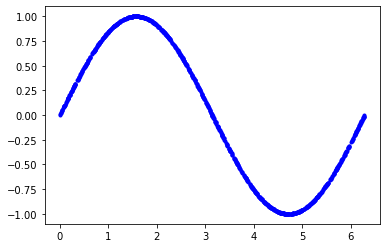

In [7]:
# Define the number of sample datapoints
SAMPLES = 1000

# Set a seed value for the random number generator
np.random.seed(1337)

# Generate a uniformly distributed set of random numbers in the range from  
# 0 to 2π, which covers a complete sine wave oscillation
x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES)

# Shuffle the values to guarantee they're not in order
np.random.shuffle(x_values)

# Calculate the corresponding sine values
y_values = np.sin(x_values)

# Plot our data. The 'b.' argument tells the library to print blue dots
plt.plot(x_values, y_values, 'b.')
plt.show()

# Adding noise
The data generated is perfect....almost too perfect. We're going to want to add some noise to it in order to simulate real-world, messy data. 

So now add some random noise to each value, then draw a new graph.

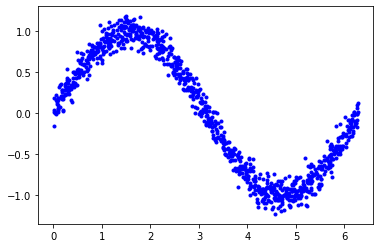

In [8]:
# Add a small random number to each y value
y_values += 0.1 * np.random.randn(*y_values.shape)

# Now plot the data
plt.plot(x_values, y_values, 'b.')
plt.show()

# Split our data
We now have a noisy dataset that approximates "real world data". We'll use this to train our model.

To evaluate the accuracy of the model we train, we'll need to compare its predictions to real data and check how well they match up. This evaluation happens during training (where it is referred to as validation), and then after training (referred to as testing). 

So we'll need to set aside some data to use for evaluation and testing - 20% and 20% respectively. The remaining 60% is used to train the model. This is a typical split for training models. 

The following code splits the data then plots each set as a different color. 

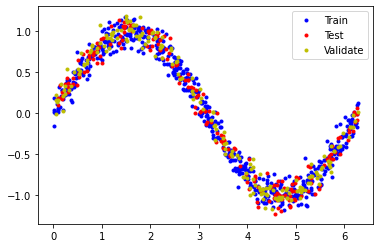

In [10]:
# Calculate the indeces for the training section of the data, and the test section.
# Validation will be from 0 to TRAIN_SPLIT, then TRAIN_SPLIT to TEST_SPLIT will be 
# the training data. Then the rest is testing data.
TRAIN_SPLIT = int(0.6 * SAMPLES)
TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)

# Use np.split to chop our data into three parts
# The second argument to np.split is an array of indices where the data will be 
# split. We provide two indices, so the data will be divided into three chunks.
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])

# Double check that splits add up correctly
assert (x_train.size + x_validate.size + x_test.size) == SAMPLES

# Plot the data in each partition in different colors
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()

# Design a model
We're going to build a model that takes an input value (in this case `x`) and use it to predict a numeric output value (the sine of `x`). This  type of problem is called a _regression_.

To achieve this, we'll create a simple neural network. It will use _layers of neurons_ to attempt to learn any patterns underlying the training data, so it can make predictions.

To begin with, we'll define two layers. The first layer takes a single input (our `x` value) and runs it through 16 neurones. Based on this input, each neuron will become _activated_ to a certain degree based on its internal state (its _weight_ and _bias_ values). A neuron's degree of activation is expressed as a number.

The activation numbers from our first layer will be fed as inputs to our second layer, which is a single neuron. It will apply its own weights and bias to these inputs and calculate its own activation, which will be output as our `y` value. 

The code in the following cell defines our model using Keras, TensorFlow's high-level API for creating deep learning networks. Once the network is defined, we _compile_ it, specifying parameters that determine how it will be trained.

In [0]:
# We'll use Keras to create a simple model architecture
from tensorflow.keras import layers
model_1 = tf.keras.Sequential()

# First layer takes a scalar input and feeds it through 16 "neurons". The
# neurons decide whether to activate based on the 'relu' activation function.
model_1.add(layers.Dense(16, activation='relu', input_shape=(1,)))

# Final layer is a single neuron, since we want to output a single value
model_1.add(layers.Dense(1))

# Compile the model using a standard optimizer and loss function for regression
model_1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

So what's going on here?

First, we're creating a Sequential model using Keras. This just means a model in which each layer of neurons is stacked on top of the next. Then we define two layers.

## First Layer

The first layer has a single input - our `x` value - and 16 neurons. It's a Dense layer, also known as a fully connected layer, meaning the input will be fed into every single one of its neurons during inference, when we're making predictions. 

The _activation function_ is a mathematical function used to shape the output of the neuron. In our network, we're using an activation function called _rectified lineaer unit_ or _ReLU_ for short. ReLU returns whichever is the larger value: its input, or zero. If its input value is negative, ReLU returns zero. If its input value is above zero, ReLU returns it unchanged. 

Without an activation function, the neuron's output would always be a linear function of its input. This would mean that the network could model only linear relationships in which the ratio between x and y remains the same across the entire range of values. This would prevent a network from modeling our sine wave, because a sine wave is nonlinear. And since ReLU is nonlinear, it allows multiple layers of neurons to join forces and model complex nonlinear relationships, in which the y value doesn't increase by the same amount for every increment of x.

## Second layer
The activation numbers from our first layer will be fed as inputs to our second layer. Because this layer is a single neuron, it will receive 16 inputs, one for each of the neurons in the previous layer. Its purpose is to combine all of the activations from the previous layer into a single output value. Since this is our output layer, we don't specify an activation function - we just want the raw result.

Because this neuron has multiple inputs, it has a corresponding weight value for each. The neuron's output is calculated by the following formula, shown in Python:
` output = sum((inputs * weights)) * bias`. The output value is obtained by multiplying each input with its corresponding weight, summing the results, and then adding in the neuron's bias. **The network's weights and biases are learned during training.** 

## Compiling
The `compile()` step in the code configures some important arguments used in the training process, and prepares the model to be trained.

The `optimizer` argument specifies the algorithm that will adjust the network to model its input during training. There are several choices, and finding the best one often comes down to experimentation. 

The `loss` argument specifies the method used during training to calculate how far the network's predictions are from reality. This method is called a _loss function_. Here, we're using `mse` or _mean squared error_. This loss function is used in the case of regressino problems, for which we're trying to predict a number.

The `metrics` argument allows us to specify some additional functions that are used to judge the performance of our model. We specify `mae` or _mean absolute error_, which is helpful for measuring the performance of a regression model. This metric will be measured during training, and we'll have access to the results after training is done. 

After compiling the model, we can use the following line to print some summary information about its architecture:

In [15]:
# Print a summary of the model's architecture
model_1.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                32        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 49
Trainable params: 49
Non-trainable params: 0
_________________________________________________________________


The table shows the layers of the network, their output shapes, and their numbers of parameters. **The size of a network - how much memory it takes up - depends mostly on its number of parameters, meaning its total number of weights and biases. This can be a useful metric when discussing model size and complexity.**


# Training our model
After defining our model, it's time to train it and then evaluate its performance to see how well it works. The metrics will tell us if it's good enough, or if we need to make changes to our design and train it again.

To train a model in Keras, we just call its `fit()` method, passing all of our data and some other important arguments. The code in the next cell shows how:


In [16]:
# Train the model on our training data while validating on our validation set 
history_1 = model_1.fit(x_train, y_train, epochs=1000, batch_size=16,
                        validation_data=(x_validate, y_validate))

Epoch 1/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.4094 - mae: 0.5590 - val_loss: 0.4553 - val_mae: 0.5831
Epoch 2/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.3715 - mae: 0.5277 - val_loss: 0.4178 - val_mae: 0.5665
Epoch 3/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.3370 - mae: 0.5077 - val_loss: 0.3845 - val_mae: 0.5410
Epoch 4/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.3116 - mae: 0.4877 - val_loss: 0.3544 - val_mae: 0.5108
Epoch 5/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2890 - mae: 0.4691 - val_loss: 0.3254 - val_mae: 0.4908
Epoch 6/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2680 - mae: 0.4521 - val_loss: 0.2985 - val_mae: 0.4765
Epoch 7/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2464 - mae: 0.4354 - val_loss: 0.2767 - val_mae: 0.4602
Epoch 8/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.

Time to explore the arguments of the `fit()` function's arguments:

`x_train, y_train`

The first two arguments to `fit()` are the x and y values of our training data. Remember that parts of our data are kept aside for validation and testing, so only the training set is used to train the network.

`epochs`

The next argument specifies how many times our entire training set will be run through the network during training. The more epochs, the more training will occur. **You might think that the more training happens, the better the network will be. However, some networks will start to overfit their training data after a certain number of epochs, so we might want to limit the amount of training we do. In addition, even if there's no overfitting, a network will stop improving after a certain amount of training.** Since training costs time and computational resources, it's best not to train if the network isn't getting better.

We're starting out with 1,000 epochs of training. When training is complete, we can dig into our metrics to discover whether this is the correct number.

`batch_size`

The `batch_size` argument specifies how many pieces of training data to feed into the network before measuring its accuracy and updating its weights and biases. If we wanted, we could specify a `batch_size` of `1`, meaning we'd run inference on a single datapoint, measuring the loss of the network's prediction, update the weights and biases to make the prediction more accurate next time, and then continue this cycle for the rest of the data. 

**Because we have 600 datapoints, each epoch would result in 600 updates to the network. This is a lot of computation, so our training would take ages.** An alternative might be to select and run inference on multiple datapoints, measure the loss in aggregate, and then update the network accordingly.

If we set `batch_size` to `600`, each batch would include all of our training data. We'd now have to make only one update to the network every epoch - much quicker. The problem is that this results in less accurate models. Research has shown that models trained with large batch sizes have less ability to generalize to new data - they are more likely to overfit.

The compromise is to use a small batch size - start with something like 16 or 32 and experiment from there to see what works best. 

`validation_data`

This is where we specify our validation dataset. Data from this dataset will be run through the network throughout the training process, and the network's predictions will be compared with the expected values. We'll see the results of validation in the logs and as part of the `history_1` object.

# Training Metrics
Time to check the metrics to see how well our network has learned. To begin, let's look at the logs written during training. This will show how the network has improved during training from its random initial state.

The log for our very first epoch is:
`Epoch 1/1000
38/38 [==============================] - 0s 6ms/step - loss: 0.4094 - mae: 0.5590 - val_loss: 0.4553 - val_mae: 0.5831`

The log for our very last epoch is:
`Epoch 1000/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.1548 - mae: 0.3076 - val_loss: 0.1550 - val_mae: 0.3116`

The `loss`, `mae`, and `val_mae` tell us various things:

`loss`

This is the output of our loss function. We're using mean squared error, which is expressed as a positive number. Generally, the smaller the loss value, the better, so this is a good thing to watch as we evaluate our network.

Comparing the first and last epochs, the network has clearly improved during training, going from a loss of ~0.4 to ~0.15

`mae` 

This is the mean absolute error of our training data. It shows the average difference between the network's predictions and the expected y values from the training data. 

We can expect our initial error to be pretty dismal, given that it's based on an untrained network. This is confirmed - our MAE is ~0.56 (range of -1 to 1). This is large. But even after training, our mse is ~0.3 which is still quite awful.

`val_loss`

This is the output of our loss function on our validation data. In our final epoch, the training loss (\~0.15) is slightly lower than the validation loss (\~0.17). This is a hint that our network might be overfitting, because it is performing worse on data it has not seen before. 

`val_mse` 

This is the mse for our validation data. With a value of 0.32, it's worse than the mse on our training set, which is another sign of overfitting. 

# Graphing the history
